In [82]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
import itertools
import pyomo.environ as env
import ast
from pyomo.environ import *
#solver = env.SolverFactory("ipopt")

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [83]:
import watertap as wt

In [84]:
#### MODEL FUNCTIONS ####

In [85]:
# LINKS COMING OUT OF SOURCE NODE AND GOING INTO FIRST UP MUST EQUAL FEEDWATER TOTAL! 
def source_flow_constraint(m, source_node): #RENAME THIS CONSTRAINT
    
    sum_of_inflows = 0
    for link in T.out_edges(source_node):
        link_name = T.edges[link]['name']
        sum_of_inflows = sum_of_inflows + m.FlowInLinkSegments[link_name]

    max_flow_in = T.nodes[source_node]['Flow']
        
    return sum_of_inflows == max_flow_in

In [86]:
def source_recycle_flow_constraint(m, source_node): #RENAME THIS CONSTRAINT --> JUST SETTING INFLOW
    
    sum_of_inflows = 0
    for link in T.out_edges(source_node):
        link_name = T.edges[link]['name']
        sum_of_inflows = sum_of_inflows + m.RecycleFlowInLinkSegments[link_name]
            
    return sum_of_inflows == 0

In [87]:
# SOURCE FLOW MASS BALANCE
def node_mass_balance_constraint(m, node):
        
    flow_in = 0
    for i in T.in_edges(node):
        flow_in = flow_in + m.FlowInLinkSegments[T.edges[i]['name']]
    flow_out = 0
    for i in T.out_edges(node):
        flow_out = flow_out + m.FlowInLinkSegments[T.edges[i]['name']]

    return (-0.000000001, flow_in - flow_out, 0.000000001)

In [88]:
# RECYCLE FLOW MASS BALANCE
def node_recycle_mass_balance_constraint(m, node):
        
    flow_in = 0
    for i in T.in_edges(node):
        flow_in = flow_in + m.RecycleFlowInLinkSegments[T.edges[i]['name']] 

    flow_out = 0
    for i in T.out_edges(node):
        flow_out = flow_out + m.RecycleFlowInLinkSegments[T.edges[i]['name']] 

    return (-0.000000001, flow_in - flow_out, 0.000000001)

In [89]:
# RECYCLE AND SOURCE FLOW MASS BALANCE
def node_allmass_balance_constraint(m, node):
        
    flow_in = 0
    for i in T.in_edges(node):
        flow_in = flow_in + m.FlowInLinkSegments[T.edges[i]['name']] + m.RecycleFlowInLinkSegments[T.edges[i]['name']] 

    flow_out = 0
    for i in T.out_edges(node):
        flow_out = flow_out + m.FlowInLinkSegments[T.edges[i]['name']] + m.RecycleFlowInLinkSegments[T.edges[i]['name']] 

    return (-0.000000001, flow_in - flow_out, 0.000000001)

In [90]:
# recovered stream from unit process
def calculate_recovered_streams(m, link):
    if 'treated' in link:
        print('treated:', link)
        unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0] #change column names for df so easier to follow
        sum_of_source_inflows = calculate_up_source_inflow(m, unit_process)
        #sum_of_recycle_inflows = calculate_up_recycle_inflow(m, unit_process)
        sum_of_up_inflow = sum_of_source_inflows #+ sum_of_recycle_inflows
        
        return m.FlowInLinkSegments[link] == sum_of_up_inflow * T.nodes[unit_process]['recovery_factor']
    
    else: return Constraint.Skip

In [91]:
# waste stream from unit process
def calculate_waste_streams(m, link):
    if 'waste' in link:
        print('waste:', link)
        unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0] #change column names for df so easier to follow
        sum_of_source_inflows = calculate_up_source_inflow(m, unit_process)
        
        if T.nodes[unit_process]['recycle_factor'] > 0: return Constraint.Skip
        else: return m.FlowInLinkSegments[link] == sum_of_source_inflows * T.nodes[unit_process]['waste_factor']
    else: return Constraint.Skip

In [92]:
# recycle stream from unit process
def calculate_recycle_streams(m, link):
    if wt.get_graph_chars.get_link_df(T).loc[link]['type'] == 'recycle_stream':
        print('recycle:', link)
        unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0] #change column names for df so easier to follow
        sum_of_source_inflows = calculate_up_source_inflow(m, unit_process)

        #return m.RecycleFlowInLinkSegments[link] == sum_of_source_inflows * T.nodes[unit_process]['recycle_factor']
        return m.FlowInLinkSegments[link] == sum_of_source_inflows * T.nodes[unit_process]['recycle_factor']
    else: return Constraint.Skip

In [93]:
# inflow to unit process
def calculate_up_source_inflow(m, unit_process):
    
    sum_of_source_inflows = 0;
    for link in T.in_edges(unit_process): #THIS WAS PREVIOUSLY OUT EDGES
        link_name = T.edges[link]['name']
        sum_of_source_inflows = sum_of_source_inflows + m.FlowInLinkSegments[link_name]
    
    return sum_of_source_inflows

In [94]:
# inflow to unit process
def calculate_up_recycle_inflow(m, unit_process):
    
    sum_of_recycle_inflows = 0;
    for link in T.in_edges(unit_process): #THIS WAS PREVIOUSLY OUT EDGES
        link_name = T.edges[link]['name']
        sum_of_recycle_inflows = sum_of_recycle_inflows + m.RecycleFlowInLinkSegments[link_name]
    
    return sum_of_recycle_inflows

In [95]:
# recovered stream of only source water --> RENAME THIS TO FINAL STREAM
def recycle_streams_constraint1(m, link):
    if wt.get_graph_chars.get_link_df(T).loc[link]['type'] == 'recycle_stream':
        return m.FlowInLinkSegments[link] == 0 # <= 0.00000001
    #if wt.get_graph_chars.get_link_df(T).loc[link]['type'] == 'recovery_stream':
    #    return m.RecycleFlowInLinkSegments[link] == 0
    else: return Constraint.Skip

In [96]:
#THIS IS FOR END NODE!!!!! BETTER NAMING NEEDED FOR FUNCTIONS
def calculate_recovered_water(m, end_node): # AT NODE

    recovered_flow = 0; # CAN DO SUM INSTREAD with list of nodes/links? outflow_link_list = []; 

    for up_outflow_link in T.in_edges(end_node): # TO DO MAKE FUNCTION
    
        recovered_flow = recovered_flow + m.FlowInLinkSegments[T.edges[up_outflow_link]['name']]
    
    return model.RecoveredFlow[end_node] == recovered_flow

In [98]:
def max_recycle_streams(m, link): # THIS COULD BE REDONE IN FUTURE TO DETERMINE OPTIMAL AMOUNT TO RECYCLE
    if wt.get_graph_chars.get_link_df(T).loc[link]['type'] == 'recycle_stream':
        unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0]
        max_recycle_amount = m.FlowInLinkSegments[('%s_source_stream' % unit_process)] * T.nodes[unit_process]['recycle_factor']
        return m.FlowInLinkSegments[link] <= max_recycle_amount
    else: return Constraint.Skip

adding unit process to network: microfiltration_a
adding unit process to network: ultrafiltration_a
adding unit process to network: uv_a
adding unit process attributes: microfiltration_a
adding unit process attributes: ultrafiltration_a
adding unit process attributes: uv_a


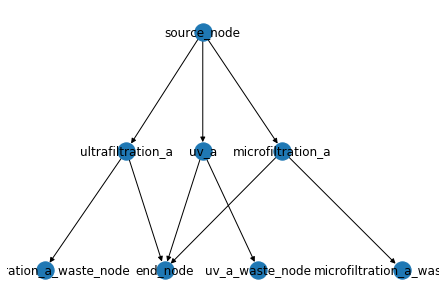

In [349]:
# imports all trains from library/unit processes
unit_process_name_list = wt.unit_process_library_list #[wt.unit_process_library_list[0], wt.unit_process_library_list[1]] 
#wt.unit_process_library_list

# FROM AND TO PROCESS TO BE CHANED TO SINGLE VS TRAIN OPTION - HAVE TWO OPTIONS. START WITH TRAIN.
T = wt.treatment_train_design.create_train(unit_process_name_list=unit_process_name_list,  # OLDER VERSION HAD TO AND FROM PROCESS BUT THAT IS FOR ADDING ONE PROCESS AT A TIME
                                            source_water_reference = 'Poseidon',
                                            source_water_type = 'Wastewater',
                                            source_water_case_study ='Typical untreated domestic wastewater',
                                            enduse_water_reference = 'Poseidon',
                                            enduse_water_type = 'Environmental',
                                            enduse_water_case_study = 'EPA: Environmental Reuse',
                                            flow = 1000.0)

wt.display.treatment_train_graph(T)

In [350]:
#recycle flow fraction could be defined from part of waste stream or based on UP chars (UP chars for now)
# how to apply to multiple streams?
#wt.treatment_train_design.
T = wt.treatment_train_design.add_recycle_stream(T,
                       from_unit_process = 'microfiltration_a',
                       to_unit_process = 'microfiltration_a',
                       recyle_fraction_of_waste = 1,
                       number_of_affected_streams = 1) #

updating unit process attributes: microfiltration_a


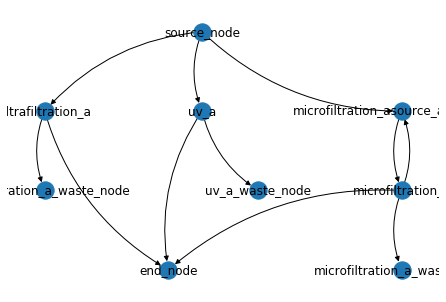

In [351]:
wt.display.treatment_train_graph(T, with_recycle = True)

In [352]:
## TO DO IMMEDIATE:
# FEEDWATER DATA CAN BE IF SOMEONE WANTS TO UPLOAD NEW!??

In [353]:
model = env.ConcreteModel()
model.LinkSet = env.Set(initialize=wt.get_graph_chars.get_link_list(T)) # all links in network
model.UnitProcesses = env.Set(initialize=unit_process_name_list) # all unit processes
model.SourceNodes = env.Set(initialize=wt.get_graph_chars.get_source_nodes(T)) # all source nodes
model.RecoveredWaterNodes = env.Set(initialize=wt.get_graph_chars.get_recovered_water_nodes(T)) # all recovered water nodes

model.AllNoneSourceEndNodes = env.Set(initialize=wt.get_graph_chars.get_all_none_source_end_nodes(T))

#inflow links to UPs
model.UnitInflowLinkSet = env.Set(initialize=wt.get_graph_chars.get_inflow_links(T, unit_process_name_list))

# flow in and out of processes
model.FlowInLinkSegments = env.Var(model.LinkSet, bounds=(0,None))
#model.RecycleFlowInLinkSegments = env.Var(model.LinkSet, bounds=(0,None))

# final recovered flow
model.RecoveredFlow = env.Var(model.RecoveredWaterNodes, bounds=(0,None))

In [354]:
model.CalculateRecoveredFlows = env.Constraint(model.LinkSet, rule=calculate_recovered_streams)
model.CalculateWasteFlows = env.Constraint(model.LinkSet, rule=calculate_waste_streams)
#model.CalculateRecycleFlows = env.Constraint(model.LinkSet, rule=calculate_recycle_streams)

treated: microfiltration_a_treated_stream
treated: ultrafiltration_a_treated_stream
treated: uv_a_treated_stream
waste: microfiltration_a_waste_stream
waste: ultrafiltration_a_waste_stream
waste: uv_a_waste_stream


In [355]:
model.CalculateRecycleRecoveredFlows1 = env.Constraint(model.LinkSet, rule=max_recycle_streams)

In [356]:
#model.CalculateRecycleRecoveredFlows2 = env.Constraint(model.LinkSet, rule=recycle_streams_constraint2)

In [357]:
# Equations for mass balance
model.NodeMassBalanceConstraint = env.Constraint(model.AllNoneSourceEndNodes, rule=node_mass_balance_constraint)

In [358]:
#model.NodeRecycleMassBalanceConstraint = env.Constraint(model.AllNoneSourceEndNodes, 
#                                                 rule=node_recycle_mass_balance_constraint)

In [359]:
#model.AllMassBalanceConstraint = env.Constraint(model.AllNoneSourceEndNodes, 
#                                                        rule = node_allmass_balance_constraint)

In [360]:
# Makes sure inlet streams add up to feedwater volume
#model.CheckUnitInletRecycleFlows = env.Constraint(model.SourceNodes, rule=source_flow_constraint)

In [361]:
model.CheckUnitInletFlows = env.Constraint(model.SourceNodes, rule=source_flow_constraint)

In [362]:
# Calculate recovered water
model.CalculateRecoveredWater = env.Constraint(model.RecoveredWaterNodes, rule=calculate_recovered_water)

In [363]:
# THIS MAKES THINGS INFEASIBLE BUT CORRECT WITH ONLY ONE UP
#model.MaxWasteREConstraint = env.Constraint(model.UnitProcesses, rule = max_waste_recycle_streams)

In [364]:
model.objective_function = env.Objective(
    #expr=sum(model.FlowInLinkSegments[x] for x in model.LinkSet), # max flows all links -> simulation
    expr=sum(model.RecoveredFlow[x] for x in model.RecoveredWaterNodes), # can do this for node?
    sense=env.maximize)

solver = env.SolverFactory("ipopt")
solver.solve(model)

/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 12, 'Number of variables': 12, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.12325692176818848}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [366]:
for x in model.LinkSet:
    print(x, ':', round(env.value(model.FlowInLinkSegments[x]), 2))

ultrafiltration_a_source_stream : 0.0
uv_a_source_stream : 0.0
microfiltration_a_source_stream : 1000.0
microfiltration_a_treated_stream : 997.5
microfiltration_a_waste_stream : 2.5
microfiltration_a_recycle_stream : 50.0
ultrafiltration_a_treated_stream : 0.0
ultrafiltration_a_waste_stream : 0.0
uv_a_treated_stream : 0.0
uv_a_waste_stream : 0.0
microfiltration_a_source_and_recycle_stream : 1050.0


In [ ]:
##### MAYBE CODES #####

In [ ]:
def add_unit_process(G, unit_process_name='unit_process', from_process_lib='False',
                    from_process='None', to_process='None'):
    print('adding unit process', unit_process_name)
    
    G.add_edges_from([('source_node', unit_process_name, {'name': 'source_stream'}), 
                      (unit_process_name, 'end_node', {'name': 'treated_stream'})])
    
    #add option to read in multiple from and to
    #add option to import for existing list if from_process_lib is true
    
    return G

In [ ]:
feedwater = dict()
for row in range(0, len(feedwater_data)):
    feedwater[feedwater_data.Variable[row]] = feedwater_data.Value[row]